# Credit Card Fraud Detection

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import skew, skewtest
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate  
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pickle

In [2]:
complete_df= pd.io.parsers.read_csv("fraudTrain.csv") 
complete_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# Preprocessing for Analysis¶
Checking for duplicate or missing values


In [3]:
duplicate = pd.DataFrame.duplicated(complete_df)
try:
    print(str(len(complete_df)/len(duplicate[duplicate.iloc[:] == True])*100)+"% are duplicate values")
    train_df.drop_duplicates(implace=True)
    complete_df.drop_duplicates(implace=True)
except ZeroDivisionError:
    print("no duplicates found")


no duplicates found


In [4]:
complete_df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

.Transforming features into a more appropriate format


In [5]:
df_grouped = complete_df.groupby(["cc_num", "first", "last"]).ngroup()
complete_df = pd.concat([complete_df, df_grouped], axis=1)
complete_df.rename(columns={0:"identifier"}, inplace=True)


In [6]:
def returnAge(dob):
    dob = dt.datetime.strptime(dob, "%Y-%m-%d").date()
    today = dt.date.today()
    return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))   
complete_df["age"] = complete_df["dob"].apply(returnAge)
complete_df.drop("dob", axis=1, inplace=True)


In [7]:
def returnTime(date_time, which):
    date_time = dt.datetime.strptime(date_time[:13], "%Y-%m-%d %H")
    if which == 0: return date_time.year
    elif which == 1: return date_time.month
    elif which == 2: return date_time.day
    elif which == 3: return date_time.hour
complete_df["year"] = complete_df["trans_date_trans_time"].apply(returnTime, which=0) 
complete_df["month"] = complete_df["trans_date_trans_time"].apply(returnTime, which=1) 
complete_df["day"] = complete_df["trans_date_trans_time"].apply(returnTime, which=2) 
complete_df["hour"] = complete_df["trans_date_trans_time"].apply(returnTime, which=3)
complete_df.drop(["trans_date_trans_time"], axis=1, inplace=True)
complete_df["long_dist"] = abs(complete_df["long"]-complete_df["merch_long"])
complete_df["lat_dist"] = abs(complete_df["lat"]-complete_df["merch_lat"])
complete_df.drop(["lat", "long", "merch_lat", "merch_long"], axis=1, inplace=True)


### Data Analysis
Testing for correlation


In [8]:
p = complete_df.corr("pearson")["is_fraud"]
s = complete_df.corr("spearman")["is_fraud"] #in text, describe differences seen
df = pd.concat([s, p], axis=1)
df.columns = ["Spearman", "Pearson"]
df.sort_values(by="Spearman", ascending=False)


,Spearman,Pearson
is_fraud,1.000000,1.000000
amt,0.087924,0.219404
hour,0.022387,0.013799
age,0.011332,0.012393
day,0.003872,0.003848
year,0.003004,0.003004
city_pop,0.001325,0.002136
lat_dist,0.000654,0.000655
cc_num,0.000412,-0.000981
identifier,0.000412,0.000392


.Testing for skewness


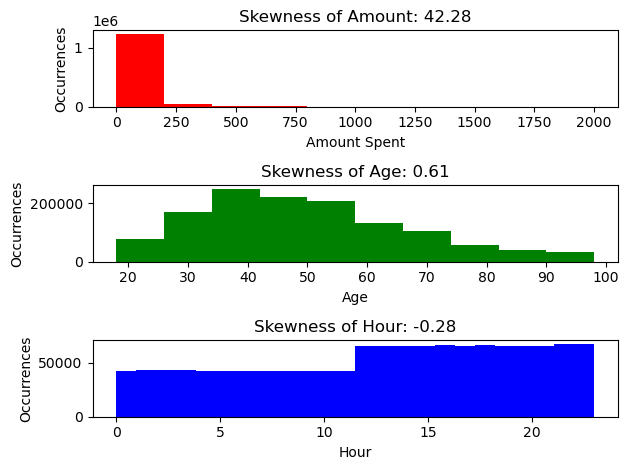

In [9]:
amt = str(round(complete_df["amt"].skew(axis = 0, skipna = True),2))
age = str(round(complete_df["age"].skew(axis = 0, skipna = True),2))
hour = str(round(complete_df["hour"].skew(axis = 0, skipna = True),2))

fig, ax = plt.subplots(3)
ax[0].hist(complete_df["amt"], 10, range=(0, 2000), histtype="stepfilled", align="mid", color="r")
ax[1].hist(complete_df["age"], 10, histtype="stepfilled", align="mid", color="g")
ax[2].hist(complete_df["hour"], 24, range=(0, 23), histtype="stepfilled", align="mid", color="b")

ax[0].set_title("Skewness of Amount: "+amt)
ax[0].set_xlabel('Amount Spent')
ax[0].set_ylabel('Occurrences')
ax[1].set_title("Skewness of Age: "+age)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Occurrences')
ax[2].set_title("Skewness of Hour: "+hour)
ax[2].set_xlabel('Hour')
ax[2].set_ylabel('Occurrences')
fig.tight_layout()             
plt.show()

In [10]:
fraud = complete_df[complete_df["is_fraud"]==1]
non_fraud = complete_df[complete_df["is_fraud"]==0]


Comparing amount spent in fraud to non-fraud


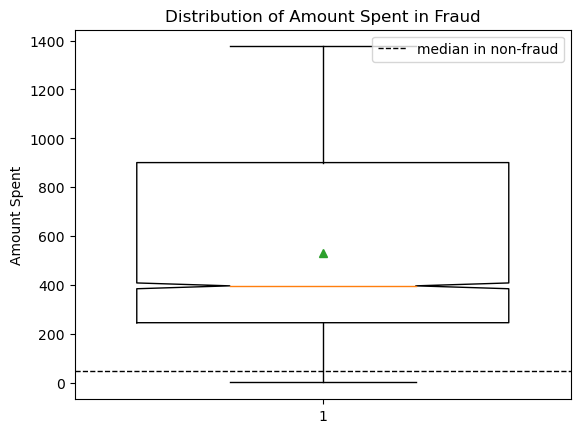

In [11]:
avg = non_fraud["amt"].median()
fraud_amt = fraud["amt"]
plt.boxplot(fraud_amt, sym="gx", widths=.75, notch=True, showmeans=True)
plt.axhline(avg, color='k', linestyle='dashed', linewidth=1, label="median in non-fraud")
plt.title("Distribution of Amount Spent in Fraud")
plt.ylabel("Amount Spent")
plt.legend(loc=1)
plt.show()

Checking for a connection between job and fraudulent transactions


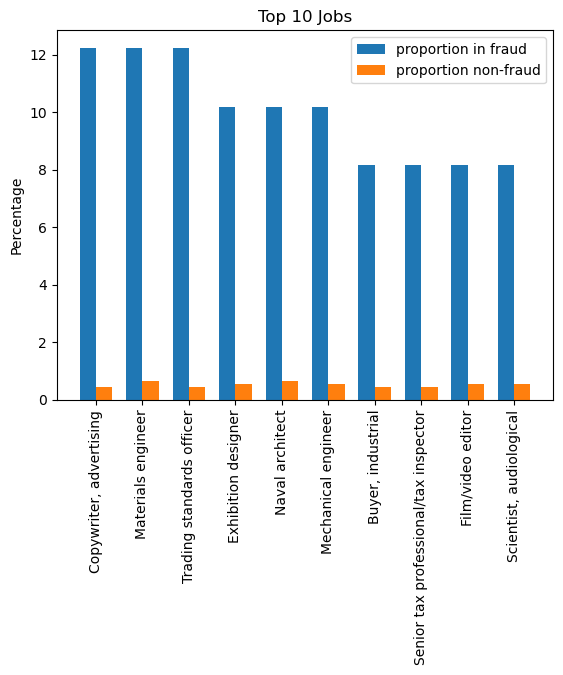

In [12]:
fraud_unique = fraud.groupby("identifier").sample()
non_fraud_unique = non_fraud.groupby("identifier").sample()

fraud_job = fraud_unique[["job"]]
counts = fraud_job.value_counts()[:10].apply(lambda x: x/fraud_job.value_counts()[:10].sum())*100
total_counts = [non_fraud_unique[non_fraud_unique["job"]==i[0]]["job"].value_counts()[0]/len(non_fraud_unique)*100 for i in counts.index] #get occurences from complete df to compare

labels = [i[0] for i in counts.index]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, counts, width, label='proportion in fraud')
rects2 = ax.bar(x + width/2, total_counts, width, label='proportion non-fraud')

ax.set_ylabel('Percentage')
ax.set_title('Top 10 Jobs')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()

Checking for a connection between category and fraudulent transactions


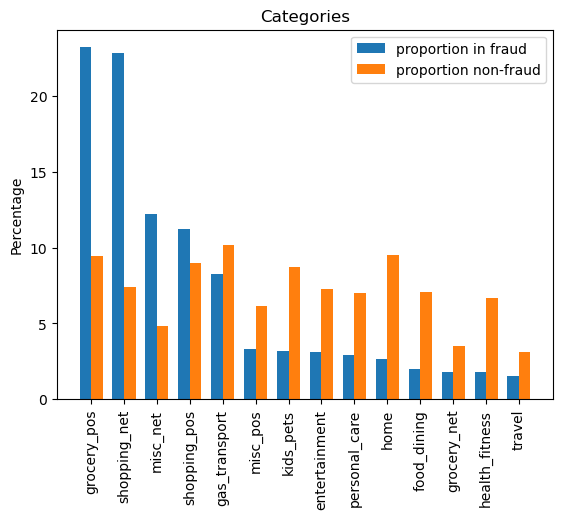

In [13]:
fraud_cat = fraud["category"]
counts = fraud_cat.value_counts().apply(lambda x: x/fraud_cat.value_counts().sum())*100
total_counts = [non_fraud[non_fraud["category"]==i]["category"].value_counts()[0]/len(non_fraud)*100 for i in counts.index] #get occurences from complete df to compare

labels = counts.index

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, counts, width, label='proportion in fraud')
rects2 = ax.bar(x + width/2, total_counts, width, label='proportion non-fraud')

ax.set_ylabel('Percentage')
ax.set_title('Categories')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()

Checking for a connection between difference in time and fraudulent transactions


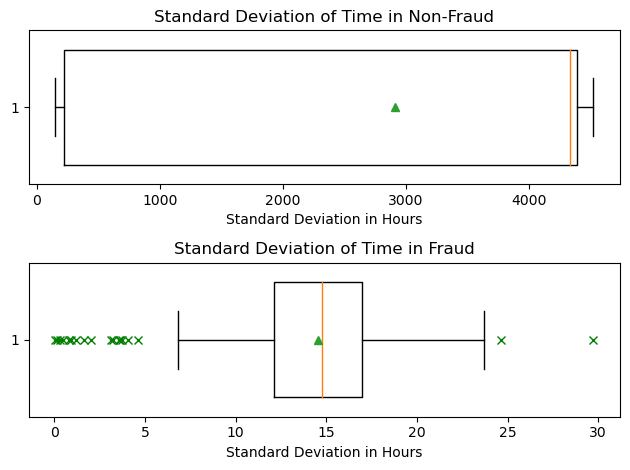

In [14]:
f = fraud.groupby(["cc_num", "month"])["unix_time"].std() 
nf = non_fraud.groupby(["cc_num", "month"])["unix_time"].std()
df = pd.concat([f, nf], axis=1, join="inner").dropna().apply(lambda x: x/(60**2))
df.columns = ["fraud", "non_fraud"]

fig, ax = plt.subplots(2)
ax[0].boxplot(df["non_fraud"], sym="gx", widths=.75, notch=False, showmeans=True, vert=False)
ax[1].boxplot(df["fraud"], sym="gx", widths=.75, notch=False, showmeans=True, vert=False)

ax[0].set_title("Standard Deviation of Time in Non-Fraud")
ax[0].set_xlabel("Standard Deviation in Hours")
ax[1].set_title("Standard Deviation of Time in Fraud")
ax[1].set_xlabel("Standard Deviation in Hours")
fig.tight_layout()             
plt.show()


Checking for a connection between distance in coordinates and fraudulent transactions


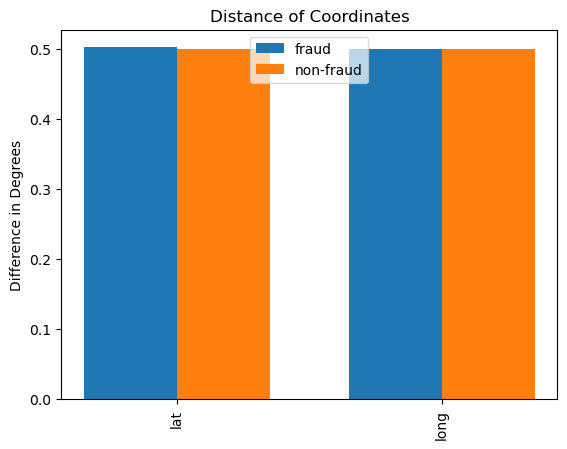

In [15]:
fraud_lat = fraud["lat_dist"]
fraud_long = fraud["long_dist"]
lat = non_fraud["lat_dist"]
long = non_fraud["long_dist"]


v_1 = [fraud_lat.mean(), fraud_long.mean()]
v_2 = [lat.mean(), long.mean()]
y = ["lat", "long"]

x = np.arange(len(y))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, v_1, width, label='fraud')
rects2 = ax.bar(x + width/2, v_2, width, label='non-fraud')

ax.set_ylabel('Difference in Degrees')
ax.set_title('Distance of Coordinates')
ax.set_xticks(x)
ax.set_xticklabels(y, rotation=90)
ax.legend(loc=9, framealpha=0.7)

plt.show()


Checking for a connection between age and fraudulent transactions


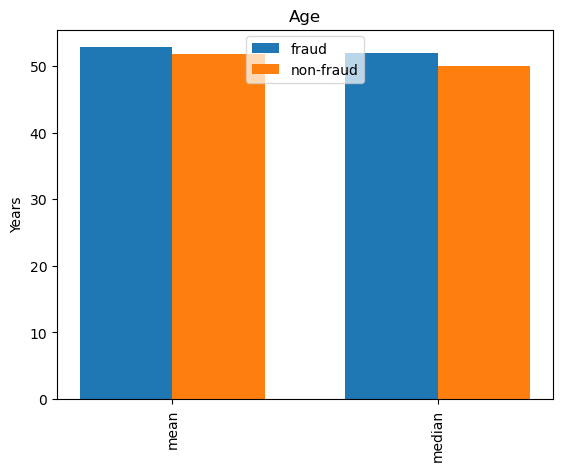

In [16]:
fraud_age = fraud.groupby("identifier").sample()["age"]
age = non_fraud.groupby("identifier").sample()["age"]


v_1 = [fraud_age.mean(), fraud_age.median()]
v_2 = [age.mean(), age.median()]
y = ["mean", "median"]

x = np.arange(len(y))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, v_1, width, label='fraud')
rects2 = ax.bar(x + width/2, v_2, width, label='non-fraud')

ax.set_ylabel('Years')
ax.set_title('Age')
ax.set_xticks(x)
ax.set_xticklabels(y, rotation=90)
ax.legend(loc=9, framealpha=0.7)

plt.show()

# Preprocessing For Training¶
Removing persoanl, irrelevant, and redundant information


In [17]:
train_df = complete_df
train_df.drop(["Unnamed: 0", "gender", "first", "last", "street", "city", "state", "zip", "trans_num", "year", "day", "month"], axis=1, inplace=True) 


Checking for imbalanced dataset


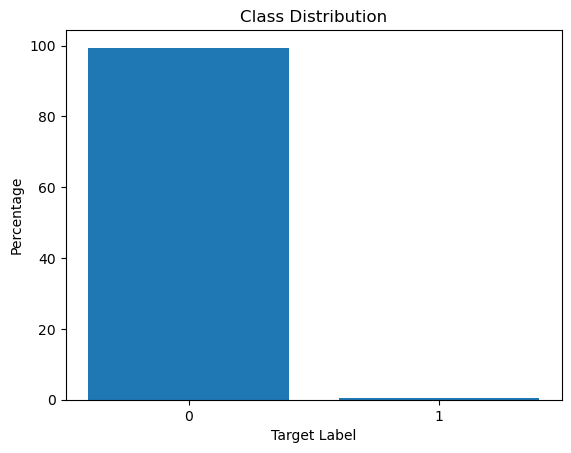

In [18]:
p_fraud = len(train_df[train_df["is_fraud"]==1])/len(train_df)*100
p_non_fraud = len(train_df[train_df["is_fraud"]==0])/len(train_df)*100
ax = plt.axes()
ax.set_ylabel('Percentage')
ax.set_xlabel('Target Label')
ax.set_title('Class Distribution')
plt.bar(["0", "1"], [p_non_fraud, p_fraud])
plt.show()

# Outlier Detection¶


In [19]:
def index_of_outliers(x): #get index of outliers for specified categories
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))
age = index_of_outliers(train_df["age"])[0] #547
amt = index_of_outliers(train_df["amt"])[0] #67290
long = index_of_outliers(train_df["long_dist"])[0] #0
lat = index_of_outliers(train_df["lat_dist"])[0] #0
indices = np.concatenate((age, [i for i in amt if i not in age])) #concatenate them
train_df.loc[indices, 'outlier'] = 1 #create new column
train_df['outlier'] = train_df['outlier'].fillna(0)


## Encoding Categorical Variables


In [20]:
lm = len(train_df["merchant"].unique())
lc = len(train_df["category"].unique())
lj = len(train_df["job"].unique())
print("merchant: "+str(lm)+"\ncategory: "+str(lc)+"\njob: "+str(lj))


merchant: 693
category: 14
job: 494


In [21]:
freq_m = train_df["merchant"].value_counts(normalize=True)*1000 #low value
freq_c = train_df["category"].value_counts(normalize=True)*10
freq_j = train_df["job"].value_counts(normalize=True)*1000
train_df["merchant"] = train_df["merchant"].map(freq_m)
train_df["category"] = train_df["category"].map(freq_c)
train_df["job"] = train_df["job"].map(freq_j)


# Building the Model


In [22]:
X = train_df.drop("is_fraud" ,axis=1)
y = train_df["is_fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)


In [ ]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
GBC = GradientBoostingClassifier(n_estimators=100,subsample=1.0,max_depth=8, \
    learning_rate=0.1,random_state=1)
smote = SMOTE()
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

x_smote, y_smote = smote.fit_resample(X_train, y_train)
score = cross_validate(GBC, x_smote, y_smote, scoring=['recall', "f1"], cv=kf, n_jobs=-1)


In [ ]:
print("Recall: "+str(np.mean(score["test_recall"]))+"\nF1-Score: "+str(np.mean(score["test_f1"])))

In [ ]:
GBC.fit(X_train, y_train)
y_pred = GBC.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Recall: {}\nPrecision: {}\nF1-Score: {}\nAccuracy: {}\n".format(rf_Recall, rf_Precision, rf_f1, rf_accuracy))
print(cm)


In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
y_prob = GBC.predict_proba(X_test)
print("AUC-ROC Curve for GradientBoost: "+str(roc_auc))

def auc_roc_c(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
auc_roc_c(y_test, y_prob[:, 1])